In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.types import *
import time

In [2]:
import findspark
findspark.init()

In [3]:
conf = SparkConf()
conf.set('spark.driver.cores', 6)
conf.set('spark.executor.cores',6)
conf.set('spark.executor.instances', 8)
conf.set('spark.driver.memory', '4g')
conf.set('spark.default.parallelism', 6)
conf.setMaster('local').setAppName('MovieRecommender')
sc = SparkContext(conf = conf)

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
sc.master

'local'

In [6]:
print(sc.defaultParallelism)

6


In [7]:
print('Cluster Manager', conf.get('spark.master'))
print('Cores', conf.get('spark.executor.cores'))
print('Memory per Driver:', conf.get('spark.driver.memory'))

Cluster Manager local
Cores 6
Memory per Driver: 4g


In [8]:
movies_df = spark.read.option('header', True).csv('ml-latest/movies.csv')

In [9]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [10]:
movies_df.filter('movieId == 3').select('title').show()

+--------------------+
|               title|
+--------------------+
|Grumpier Old Men ...|
+--------------------+



In [11]:
movies_df.summary().show()

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|             58098|               58098|             58098|
|   mean|111919.51619677097|                null|              null|
| stddev|59862.660955928804|                null|              null|
|    min|                 1|"""Great Performa...|(no genres listed)|
|    25%|           72424.0|                null|              null|
|    50%|          126510.0|                null|              null|
|    75%|          161438.0|                null|              null|
|    max|             99999|     줄탁동시 (2012)|           Western|
+-------+------------------+--------------------+------------------+



In [12]:
ratings_df = spark.read.option('header', True).csv('ml-latest/ratings.csv')

In [13]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
|     1|   1590|   2.5|1256677236|
|     1|   1591|   1.5|1256677475|
|     1|   2134|   4.5|1256677464|
|     1|   2478|   4.0|1256677239|
|     1|   2840|   3.0|1256677500|
|     1|   2986|   2.5|1256677496|
|     1|   3020|   4.0|1256677260|
|     1|   3424|   4.5|1256677444|
|     1|   3698|   3.5|1256677243|
|     1|   3826|   2.0|1256677210|
|     1|   3893|   3.5|1256677486|
|     2|    170|   3.5|1192913581|
|     2|    849|   3.5|1192913537|
|     2|   1186|   3.5|1192913611|
|     2|   1235|   3.0|1192913585|
+------+-------+------+----------+
only showing top 20 rows



In [14]:
ratings_df.summary().show()

+-------+------------------+-----------------+------------------+--------------------+
|summary|            userId|          movieId|            rating|           timestamp|
+-------+------------------+-----------------+------------------+--------------------+
|  count|          27753444|         27753444|          27753444|            27753444|
|   mean|141942.01557064414|18487.99983414671|3.5304452124932677|1.1931218549319255E9|
| stddev| 81707.40009148893|35102.62524746777|1.0663527502319803|2.1604822852233458E8|
|    min|                 1|                1|               0.5|          1000000065|
|    25%|           71210.0|           1099.0|               3.0|        9.98614809E8|
|    50%|          142009.0|           2716.0|               3.5|       1.174252114E9|
|    75%|          212470.0|           7151.0|               4.0|       1.422730806E9|
|    max|             99999|            99999|               5.0|           999999978|
+-------+------------------+---------------

In [15]:
movielens = movies_df.join(ratings_df, ['movieId'],'left')

In [ ]:
# movielens.summary().show()

In [16]:
movielens.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [17]:
from pyspark.sql.types import IntegerType
movielens = movielens.withColumn('userId', movielens['userId'].cast(IntegerType()))
movielens = movielens.withColumn('rating', movielens['rating'].cast(IntegerType()))
movielens = movielens.withColumn('movieId', movielens['movieId'].cast(IntegerType()))

In [18]:
movielens.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [19]:
movielens.columns

['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp']

In [20]:
movielens.createOrReplaceTempView('Movies')

In [21]:
spark.sql('select * from Movies where genres == "Comedy" AND rating == 5').show()

+-------+--------------------+------+------+------+----------+
|movieId|               title|genres|userId|rating| timestamp|
+-------+--------------------+------+------+------+----------+
|   1425|Fierce Creatures ...|Comedy|     4|     5|1113796433|
|    141|Birdcage, The (1996)|Comedy|     6|     5| 832039987|
|    141|Birdcage, The (1996)|Comedy|     8|     5| 858269303|
|    223|       Clerks (1994)|Comedy|    10|     5| 948883834|
|   1202| Withnail & I (1987)|Comedy|    10|     5| 948967730|
|   1288|This Is Spinal Ta...|Comedy|    10|     5| 948887548|
|  86377|Louis C.K.: Shame...|Comedy|    15|     5|1370809693|
|  92535|Louis C.K.: Live ...|Comedy|    15|     5|1370809690|
|    348|Bullets Over Broa...|Comedy|    16|     5| 829558966|
|    223|       Clerks (1994)|Comedy|    18|     5| 845061796|
|    305|Ready to Wear (Pr...|Comedy|    19|     5| 836434015|
|   2791|    Airplane! (1980)|Comedy|    26|     5|1225232932|
|   2792|Airplane II: The ...|Comedy|    26|     5|1225

In [22]:
spark.sql('select * from Movies where userId == 1 AND rating == 5 OR genres == "Romance"').show()

+-------+--------------------+-------+------+------+----------+
|movieId|               title| genres|userId|rating| timestamp|
+-------+--------------------+-------+------+------+----------+
| 103368|Love and Lemons (...|Romance| 14691|     3|1414780445|
| 103368|Love and Lemons (...|Romance| 42010|     2|1485195310|
| 103368|Love and Lemons (...|Romance| 52165|     3|1372604722|
| 103368|Love and Lemons (...|Romance| 70515|     2|1492007380|
| 103368|Love and Lemons (...|Romance|123100|     3|1450162851|
| 103368|Love and Lemons (...|Romance|196235|     4|1467276663|
| 103368|Love and Lemons (...|Romance|223722|     3|1415377399|
| 103368|Love and Lemons (...|Romance|226489|     2|1492007403|
| 103368|Love and Lemons (...|Romance|231746|     4|1528923070|
| 104472|    Find Love (2006)|Romance| 48470|     2|1377417309|
|   1159|Love in Bloom (1935)|Romance|  1364|     1| 948395874|
|   1159|Love in Bloom (1935)|Romance|  7642|     5| 964650020|
|   1159|Love in Bloom (1935)|Romance|  

In [23]:
print(spark.catalog.listTables())

[Table(name='movies', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [24]:
#Select movies with the most reviews in descending order
query = 'SELECT title, count(*) as reviews from Movies group by title order by reviews desc'
spark.sql(query).show()

+--------------------+-------+
|               title|reviews|
+--------------------+-------+
|Shawshank Redempt...|  97999|
| Forrest Gump (1994)|  97040|
| Pulp Fiction (1994)|  92406|
|Silence of the La...|  87899|
|  Matrix, The (1999)|  84545|
|Star Wars: Episod...|  81815|
|Jurassic Park (1993)|  76451|
|Schindler's List ...|  71516|
|   Braveheart (1995)|  68803|
|    Toy Story (1995)|  68469|
|Star Wars: Episod...|  66023|
|Star Wars: Episod...|  65822|
|   Fight Club (1999)|  65678|
|Terminator 2: Jud...|  64258|
|Raiders of the Lo...|  63505|
|Usual Suspects, T...|  62180|
|Lord of the Rings...|  61883|
|Godfather, The (1...|  60904|
|American Beauty (...|  60820|
|Independence Day ...|  58949|
+--------------------+-------+
only showing top 20 rows



In [25]:
print('Number of different users: {}'.format(movielens.select('userId').distinct().count()))
print('Number of different movies: {}'.format(movielens.select('movieId').distinct().count()))
print('Number of movies with at least on rating strictly higher than 4: {}'.format(movielens.filter('rating > 4').select('movieId').distinct().count()))

Number of different users: 283229
Number of different movies: 58098
Number of movies with at least on rating strictly higher than 4: 24209


In [26]:
print('Number of movies that are considered Comedy: {}'.format(movielens.filter(movielens.genres.contains('Comedy')).select('movieId').distinct().count()))
print('Number of Comedies that are rated 5: {}'.format(movielens.filter(movielens.genres.contains('Comedy')).filter('rating == 5').select('movieId').distinct().count()))

Number of movies that are considered Comedy: 15956
Number of Comedies that are rated 5: 7552


In [27]:
comedy_df = movielens.filter(movielens.genres.contains('Comedy'))
grouped_df = comedy_df.groupBy('title').count()
sorted_df = grouped_df.sort(grouped_df['count'].desc())

In [28]:
sorted_df.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
| Forrest Gump (1994)|97040|
| Pulp Fiction (1994)|92406|
|    Toy Story (1995)|68469|
|Back to the Futur...|57492|
|        Fargo (1996)|54500|
|      Aladdin (1992)|51839|
|    True Lies (1994)|50864|
|        Shrek (2001)|46826|
|Ace Ventura: Pet ...|45608|
|Men in Black (a.k...|44287|
|Princess Bride, T...|42878|
|Monty Python and ...|40866|
|Groundhog Day (1993)|40836|
|Pirates of the Ca...|39674|
|    Mask, The (1994)|38699|
|Batman Forever (1...|38647|
| Pretty Woman (1990)|38504|
|Mrs. Doubtfire (1...|38484|
|Dumb & Dumber (Du...|37823|
|Amelie (Fabuleux ...|37167|
+--------------------+-----+
only showing top 20 rows



In [29]:
first_row = sorted_df.first()
print('Movie that has the most 5 star rating: {}'.format(first_row.title))

Movie that has the most 5 star rating: Forrest Gump (1994)


In [30]:
#Movie that has the most 1 star rating
one_df = movielens.filter('rating == 1.0')
rat_df = one_df.groupBy('rating', 'title').count()
sort_rat_df = rat_df.sort(rat_df['count'].desc())
worst_mov = sort_rat_df.first().title
print('Movie that has the most 1 star rating: {}'.format(worst_mov))

Movie that has the most 1 star rating: Ace Ventura: Pet Detective (1994)


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

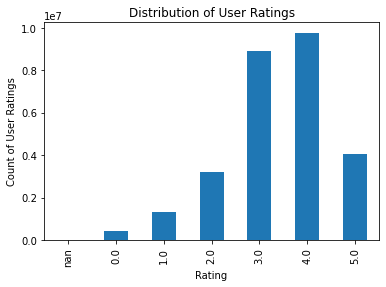

In [32]:
ratings_hist = (movielens.groupBy(col('rating')).count().sort(col('rating').asc())).toPandas()
ratings_hist.plot.bar('rating', 'count')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of User Ratings')
plt.legend().remove()
plt.show()

In [33]:
avg_genre_rating = (movielens.select('movieId', 'userId', 'genres', 'rating').withColumn('genres_array', f.split('genres', '\|')).withColumn('genre', f.explode('genres_array')).groupBy('genre').agg(f.mean(f.col('rating')).alias('genre_rating'),f.countDistinct('movieId').alias('num_movies'),f.countDistinct('movieId','userId').alias('num_ratings'))).toPandas()

Text(0.5, 1.0, 'Visualizing Number of Movies for Each Genre')

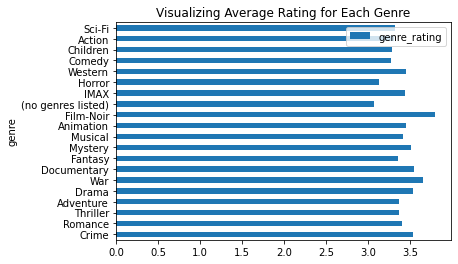

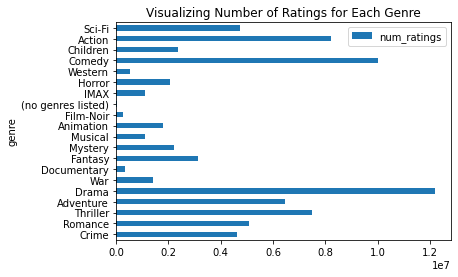

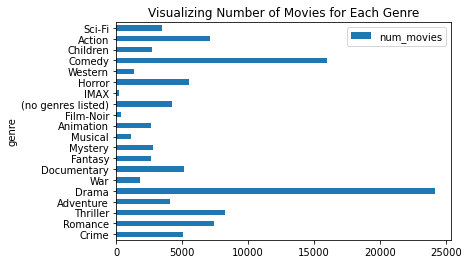

In [34]:
avg_genre_rating.plot.barh('genre', 'genre_rating')
plt.title('Visualizing Average Rating for Each Genre')
avg_genre_rating.plot.barh('genre', 'num_ratings')
plt.title('Visualizing Number of Ratings for Each Genre')
avg_genre_rating.plot.barh('genre', 'num_movies')
plt.title('Visualizing Number of Movies for Each Genre')

In [35]:
#Release Year
release_year_rating = (movielens.select('title', 'movieId', 'userId', 'rating').withColumn('releaseyear', f.substring('title',-5,4)).filter(f.col('releaseyear')>1900).groupBy('releaseyear').agg(f.mean(f.col('rating')).alias('avg_rating'),f.countDistinct('movieId').alias('num_movies'),f.countDistinct('movieId','userId').alias('num_ratings'))).toPandas()

In [36]:
release_year_rating.sort_values(by=['num_movies'], ascending = False)

,releaseyear,avg_rating,num_movies,num_ratings
101,2015,3.354489,2311,278900
22,2014,3.417197,2294,356580
5,2016,3.323733,2219,204613
25,2013,3.282195,2173,336980
7,2012,3.343568,1993,362019
...,...,...,...,...
9,1910,2.857143,12,56
17,1911,3.317073,10,41
48,1905,2.590909,8,22
52,1904,3.137931,8,29


Text(0.5, 1.0, 'Visualizing Number of Movies vs Release Year')

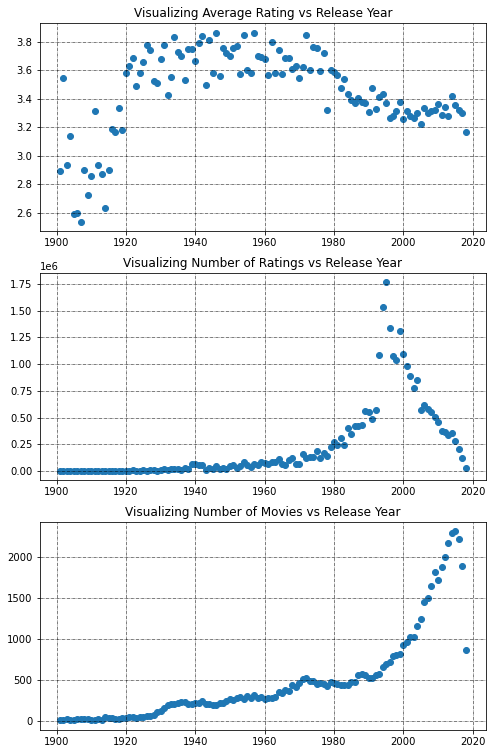

In [37]:
plt.figure(figsize = (8,13))
plt.subplot(3, 1, 1)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.avg_rating)
plt.grid(color = 'k', linestyle = '-.', linewidth = 0.5)
plt.title('Visualizing Average Rating vs Release Year')
plt.subplot(3, 1, 2)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.num_ratings)
plt.grid(color = 'k', linestyle = '-.', linewidth = 0.5)
plt.title('Visualizing Number of Ratings vs Release Year')
plt.subplot(3, 1, 3)
plt.scatter(release_year_rating.releaseyear.astype('int64'),release_year_rating.num_movies)
plt.grid(color = 'k', linestyle = '-.', linewidth = 0.5)
plt.title('Visualizing Number of Movies vs Release Year')

In [38]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [39]:
movielens.summary().show()

+-------+------------------+--------------------+------------------+------------------+------------------+--------------------+
|summary|           movieId|               title|            genres|            userId|            rating|           timestamp|
+-------+------------------+--------------------+------------------+------------------+------------------+--------------------+
|  count|          27757653|            27757653|          27757653|          27753444|          27753444|            27753444|
|   mean|18507.621371914982|                null|              null|141942.01557064414| 3.385687124091698|1.1931218549319255E9|
| stddev|  35137.3348485171|                null|              null| 81707.40009148847|1.1139728783833662|2.1604822852234027E8|
|    min|                 1|"""Great Performa...|(no genres listed)|                 1|                 0|          1000000065|
|    25%|              1097|                null|              null|             71175|                 

In [40]:
movielens_df = movielens.filter(movielens.userId.isNotNull())

In [41]:
movielens_df = movielens_df.filter(movielens_df.movieId.isNotNull())

In [42]:
movielens_df.summary().show()

+-------+-----------------+--------------------+------------------+------------------+------------------+--------------------+
|summary|          movieId|               title|            genres|            userId|            rating|           timestamp|
+-------+-----------------+--------------------+------------------+------------------+------------------+--------------------+
|  count|         27753444|            27753444|          27753444|          27753444|          27753444|            27753444|
|   mean|18487.99983414671|                null|              null|141942.01557064414| 3.385687124091698|1.1931218549319255E9|
| stddev|35102.62524746777|                null|              null| 81707.40009148893|1.1139728783833733|2.1604822852233458E8|
|    min|                1|"""Great Performa...|(no genres listed)|                 1|                 0|          1000000065|
|    25%|             1099|                null|              null|             71210|                 3|      

In [43]:
train,test = movielens_df.randomSplit([0.8, 0.2], seed = 42)

In [44]:
als = ALS(rank = 10, maxIter = 10, regParam = 0.1, userCol = 'userId', itemCol = 'movieId', ratingCol = 'rating', coldStartStrategy = 'drop')

In [45]:
time_start = time.time()
model = als.fit(train)
time_end = time.time() - time_start

print(time_end)

173.67227816581726


In [46]:
pred = model.transform(test)

In [47]:
pred.show()

+-------+--------------------+--------------------+------+------+----------+----------+
|movieId|               title|              genres|userId|rating| timestamp|prediction|
+-------+--------------------+--------------------+------+------+----------+----------+
|     45|   To Die For (1995)|Comedy|Drama|Thri...|    12|     3|1108087163| 2.1131363|
|    596|    Pinocchio (1940)|Animation|Childre...|    12|     2|1108087132| 2.3734608|
|   1090|      Platoon (1986)|           Drama|War|    12|     3|1108087090| 2.5467796|
|   2353|Enemy of the Stat...|     Action|Thriller|    12|     2|1108087149| 2.4383225|
|    594|Snow White and th...|Animation|Childre...|    22|     3|1237622610| 3.3298824|
|    919|Wizard of Oz, The...|Adventure|Childre...|    22|     4|1237622618|  3.505258|
|    953|It's a Wonderful ...|Children|Drama|Fa...|    22|     3|1237622628| 3.6557693|
|   1588|George of the Jun...|     Children|Comedy|    22|     4|1237622408| 2.2654922|
|   1894|Six Days Seven Ni...|Ad

In [48]:
# pred.na.drop()

In [49]:
eval = RegressionEvaluator(metricName = 'rmse', labelCol = 'rating', predictionCol = 'prediction')

In [50]:
rmse = eval.evaluate(pred)

In [51]:
rmse

0.85318583981638

In [52]:
user_2 = test.filter(test['userId'] == 2).select(['userId', 'movieId', 'title', 'rating'])

In [53]:
user_2.show()

+------+-------+--------------------+------+
|userId|movieId|               title|rating|
+------+-------+--------------------+------+
|     2|   1235|Harold and Maude ...|     3|
|     2|   1663|      Stripes (1981)|     3|
|     2|   2108|   L.A. Story (1991)|     3|
+------+-------+--------------------+------+



In [54]:
rec = model.transform(user_2)
prediction_whole = rec.withColumn('prediction', f.round(rec['prediction']).cast('integer'))
prediction_bound = prediction_whole.withColumn('prediction', f.when(prediction_whole['prediction'] >= 5, 5).when(prediction_whole['prediction'] <= 0, 0).otherwise(prediction_whole['prediction']))
prediction_bound.orderBy('prediction', ascending=False).show()

+------+-------+--------------------+------+----------+
|userId|movieId|               title|rating|prediction|
+------+-------+--------------------+------+----------+
|     2|   1235|Harold and Maude ...|     3|         4|
|     2|   1663|      Stripes (1981)|     3|         3|
|     2|   2108|   L.A. Story (1991)|     3|         3|
+------+-------+--------------------+------+----------+



In [55]:
from pyspark.sql.functions import lit

def recommendMovies(model, user, nbRecommendations):
    dataset = movielens.select('movieId', 'title', 'genres').distinct().withColumn('userId', lit(user))
    
    moviesAlreadyRated = movielens.filter(movielens.userId == user).select('movieId', 'title', 'genres','userId')
    
    predictions = model.transform(dataset.subtract(moviesAlreadyRated)).dropna().orderBy('prediction', ascending=False).limit(nbRecommendations).select('movieId', 'title', 'genres', 'prediction')
    
    prediction_whole = predictions.withColumn('prediction', f.round(predictions['prediction']).cast('integer'))
    prediction_bound = prediction_whole.withColumn('prediction', f.when(prediction_whole['prediction'] >= 5, 5).when(prediction_whole['prediction'] <= 0, 0).otherwise(prediction_whole['prediction']))
    
    return prediction_bound

In [56]:
print('Recommendations for user 2: ')
recommendMovies(model, 2, 10).toPandas()

Recommendations for user 2: 


,movieId,title,genres,prediction
0,184299,Freedom on My Mind (1994),Documentary,5
1,154402,Pünktchen und Anton (1999),Children,5
2,176363,The Children of the Marshland (1999),Comedy|Drama,5
3,160197,The Hive (2008),Horror|Sci-Fi,5
4,192089,"National Theatre Live: One Man, Two Guvnors (2...",Comedy,5
5,178147,Beatles Stories (2011),Documentary,5
6,121919,The Good Mother (2013),Drama|Mystery|Thriller,5
7,120821,The War at Home (1979),Documentary|War,5
8,157789,.hack Liminality In the Case of Yuki Aihara,(no genres listed),5
9,157791,.hack Liminality In the Case of Kyoko Tohno,(no genres listed),5


In [57]:
#Hyperparameter Tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

X_train, X_validation = movielens_df.randomSplit([0.8, 0.2], seed = 42)
paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10, 20]).addGrid(als.regParam, [0.01, 0.05, 0.1]).build()

crossval = CrossValidator(estimator = als, estimatorParamMaps = paramGrid, evaluator = eval, numFolds = 3)
print(len(paramGrid))

# cvModel = crossval.fit(X_train)
# predictions = cvModel.transform(X_validation)
# print('the root mean squared error for our model is: {}'.format(eval.evaluate(predictions)))

12


In [58]:
import time

time_start = time.time()
cvModel = crossval.fit(X_train)
time_end = time.time() - time_start

print(time_end)

4844.88573050499


In [59]:
bestModel = cvModel.bestModel

In [60]:
import numpy as np
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='ALS_c105af5c890b', name='rank', doc='rank of the factorization'): 1, Param(parent='ALS_c105af5c890b', name='regParam', doc='regularization parameter (>= 0).'): 0.01}


In [61]:
recommendMovies(bestModel, 2, 10).toPandas()

,movieId,title,genres,prediction
0,184299,Freedom on My Mind (1994),Documentary,5
1,192089,"National Theatre Live: One Man, Two Guvnors (2...",Comedy,5
2,190707,1968 (2018),(no genres listed),5
3,166812,Seeing Red: Stories of American Communists (1983),(no genres listed),5
4,185959,Wajib (2017),Drama,5
5,120821,The War at Home (1979),Documentary|War,5
6,189643,The Cakemaker (2017),Drama,5
7,176363,The Children of the Marshland (1999),Comedy|Drama,5
8,157789,.hack Liminality In the Case of Yuki Aihara,(no genres listed),5
9,157791,.hack Liminality In the Case of Kyoko Tohno,(no genres listed),5


In [62]:
predictions = bestModel.transform(X_validation)

print('the root mean squared error for our model is: {}'.format(eval.evaluate(predictions)))

the root mean squared error for our model is: 0.8497747827347868


# To Do
1. get average ratings for each movie
2. fill in average rating into the null values
3. compare cold start to filling in na with the average
4. Make the rating whole numbers if greater than 5 cap it at 5, if less than 0 cap at 0

In [63]:
#Average rating for each movie
mean_ratings= movielens_df.groupBy('title').agg(f.avg('rating').alias('mean_rating'))

In [64]:
#Join the mean ratings with original dataframe
final_df = movielens_df.join(mean_ratings, on='title')

In [65]:
#fill the missing values with the mean rating
final_df = final_df.na.fill({'rating' : 'mean_rating'})

In [66]:
#Compare the cold start to the new dataset
X_train,X_test = final_df.randomSplit([0.8, 0.2], seed = 42)
prediction = bestModel.transform(test)
prediction_2 = bestModel.transform(X_test)
rmse = eval.evaluate(prediction)
rmse_2 = eval.evaluate(prediction_2)
print(f'Dropping null ratings from the dataset: {rmse}')
print(f'Filling null with average rating: {rmse_2}')

Dropping null ratings from the dataset: 0.8497747827347868
Filling null with average rating: 0.8020461782514533


In [67]:
#Make the ratings whole numbers and in range [0,5]
prediction_whole = prediction.withColumn('prediction', f.round(prediction['prediction']).cast('integer'))
prediction_bound = prediction_whole.withColumn('prediction', f.when(prediction_whole['prediction'] >= 5, 5).when(prediction_whole['prediction'] <= 0, 0).otherwise(prediction_whole['prediction']))

In [68]:
prediction_bound.show()

+-------+--------------------+--------------------+------+------+----------+----------+
|movieId|               title|              genres|userId|rating| timestamp|prediction|
+-------+--------------------+--------------------+------+------+----------+----------+
|     45|   To Die For (1995)|Comedy|Drama|Thri...|    12|     3|1108087163|         2|
|    596|    Pinocchio (1940)|Animation|Childre...|    12|     2|1108087132|         2|
|   1090|      Platoon (1986)|           Drama|War|    12|     3|1108087090|         3|
|   2353|Enemy of the Stat...|     Action|Thriller|    12|     2|1108087149|         2|
|    594|Snow White and th...|Animation|Childre...|    22|     3|1237622610|         3|
|    919|Wizard of Oz, The...|Adventure|Childre...|    22|     4|1237622618|         3|
|    953|It's a Wonderful ...|Children|Drama|Fa...|    22|     3|1237622628|         4|
|   1588|George of the Jun...|     Children|Comedy|    22|     4|1237622408|         2|
|   1894|Six Days Seven Ni...|Ad

In [69]:
movielens_df.tail(20)

[Row(movieId=5120, title='Sleuth (1972)', genres='Comedy|Mystery|Thriller', userId=283228, rating=4, timestamp='1379882757'),
 Row(movieId=5502, title='Signs (2002)', genres='Horror|Sci-Fi|Thriller', userId=283228, rating=3, timestamp='1354159739'),
 Row(movieId=5602, title='Ladykillers, The (1955)', genres='Comedy|Crime', userId=283228, rating=4, timestamp='1379882734'),
 Row(movieId=5706, title='...All the Marbles (1981)', genres='Comedy|Drama', userId=283228, rating=1, timestamp='1354159591'),
 Row(movieId=5989, title='Catch Me If You Can (2002)', genres='Crime|Drama', userId=283228, rating=4, timestamp='1379882974'),
 Row(movieId=6377, title='Finding Nemo (2003)', genres='Adventure|Animation|Children|Comedy', userId=283228, rating=5, timestamp='1379882837'),
 Row(movieId=6874, title='Kill Bill: Vol. 1 (2003)', genres='Action|Crime|Thriller', userId=283228, rating=4, timestamp='1354159613'),
 Row(movieId=7072, title='Stagecoach (1939)', genres='Action|Drama|Romance|Western', userId=

In [70]:
movielens_df.createOrReplaceTempView('Movies')

In [71]:
movielens_df.show(10)

+-------+--------------------+--------------------+------+------+----------+
|movieId|               title|              genres|userId|rating| timestamp|
+-------+--------------------+--------------------+------+------+----------+
|    307|Three Colors: Blu...|               Drama|     1|     3|1256677221|
|    481|   Kalifornia (1993)|      Drama|Thriller|     1|     3|1256677456|
|   1091|Weekend at Bernie...|              Comedy|     1|     1|1256677471|
|   1257|Better Off Dead.....|      Comedy|Romance|     1|     4|1256677460|
|   1449|Waiting for Guffm...|              Comedy|     1|     4|1256677264|
|   1590|Event Horizon (1997)|Horror|Sci-Fi|Thr...|     1|     2|1256677236|
|   1591|        Spawn (1997)|Action|Adventure|...|     1|     1|1256677475|
|   2134|Weird Science (1985)|Comedy|Fantasy|Sc...|     1|     4|1256677464|
|   2478|¡Three Amigos! (1...|      Comedy|Western|     1|     4|1256677239|
|   2840|     Stigmata (1999)|      Drama|Thriller|     1|     3|1256677500|

In [72]:
# What movie has the most 4 star ratings
most_four_star = 'SELECT title, count(*) as number_of_ratings from Movies where rating == 4 group by title order by number_of_ratings desc limit 1'
spark.sql(most_four_star).show()

#Movie that has the most 4 star rating
four_df = movielens_df.filter('rating == 4.0')
rat_df = four_df.groupBy('rating', 'title').count().withColumnRenamed('count', 'num_of_ratings')
sort_rat_df = rat_df.sort(rat_df['num_of_ratings'].desc())
print(f'Movie that has the most 4 star rating: {sort_rat_df.first().title} with a count of: {sort_rat_df.first().num_of_ratings}')

+--------------------+-----------------+
|               title|number_of_ratings|
+--------------------+-----------------+
|Silence of the La...|            38491|
+--------------------+-----------------+

Movie that has the most 4 star rating: Silence of the Lambs, The (1991) with a count of: 38491


In [73]:
#What movie has the most ratings
most_ratings = 'SELECT title, count(*) as number_of_ratings from Movies group by title order by number_of_ratings desc limit 1'
spark.sql(most_ratings).show()

most_ratings = movielens_df.groupBy('title').count().withColumnRenamed('count', 'num_of_reviews')
sorted_ratings = most_ratings.sort(most_ratings['num_of_reviews'].desc())
print(f'Movie that has the most ratings: {sorted_ratings.first().title} with a count of {sorted_ratings.first().num_of_reviews}')

+--------------------+-----------------+
|               title|number_of_ratings|
+--------------------+-----------------+
|Shawshank Redempt...|            97999|
+--------------------+-----------------+

Movie that has the most ratings: Shawshank Redemption, The (1994) with a count of 97999


In [74]:
#What movie has the least ratings
least_ratings = 'SELECT title, count(*) as number_of_ratings from Movies group by title order by number_of_ratings asc limit 1'
spark.sql(least_ratings).show()

sorted_ratings = most_ratings.sort(most_ratings['num_of_reviews'].asc())
print(f'Movie that has the least ratings: {sorted_ratings.first().title} with a count of {sorted_ratings.first().num_of_reviews}')

+--------------------+-----------------+
|               title|number_of_ratings|
+--------------------+-----------------+
|The 12 Disasters ...|                1|
+--------------------+-----------------+

Movie that has the least ratings: The 12 Disasters of Christmas (2012) with a count of 1


In [75]:
#Which user had the most reviews
most_reviewer = 'SELECT userId, count(*) as number_of_reviews from Movies group by userId order by number_of_reviews desc limit 1'
spark.sql(most_reviewer).show()

most_reviewer = movielens_df.groupBy('userId').count().withColumnRenamed('count', 'num_of_reviews')
sorted_reviewer = most_reviewer.sort(most_reviewer['num_of_reviews'].desc())
print(f'User with the most reviews: {sorted_reviewer.first().userId} with a count of {sorted_reviewer.first().num_of_reviews}')

+------+-----------------+
|userId|number_of_reviews|
+------+-----------------+
|123100|            23715|
+------+-----------------+

User with the most reviews: 123100 with a count of 23715


In [76]:
#Which user gave the most 5 star reviews
most_five_star_reviewer = 'SELECT userId, count(*) as five_star_reviews from Movies where rating = 5 group by userId order by five_star_reviews desc limit 1'
spark.sql(most_five_star_reviewer).show()

five_df = movielens_df.filter('rating == 5.0')
rat_df = five_df.groupBy('userId', 'rating').count().withColumnRenamed('count', 'num_of_ratings')
sort_rat_df = rat_df.sort(rat_df['num_of_ratings'].desc())
print(f'User that gave the most 5 star reviews: {sort_rat_df.first().userId} with a count of: {sort_rat_df.first().num_of_ratings}')

+------+-----------------+
|userId|five_star_reviews|
+------+-----------------+
| 70346|             2029|
+------+-----------------+

User that gave the most 5 star reviews: 70346 with a count of: 2029


In [77]:
#Which user had the highest average rating

highest_avg = 'SELECT userId, avg(rating) AS avg_rating from Movies group by userId order by avg_rating desc limit 1'
spark.sql(highest_avg).show()



+------+----------+
|userId|avg_rating|
+------+----------+
|  9376|       5.0|
+------+----------+



In [78]:
#Which movie had the highest average rating
highest_avg_rating = 'SELECT title, avg(rating) AS avg_rating from Movies group by title order by avg_rating desc limit 1'
spark.sql(highest_avg_rating).show()

+--------------------+----------+
|               title|avg_rating|
+--------------------+----------+
|The Hardy Bucks M...|       5.0|
+--------------------+----------+

